In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from tqdm.notebook import tqdm
import os

In [2]:
class ImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.df.fillna(-999, inplace=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_filename = self.df.iloc[idx]['frame'] + '.jpg'
        img_path = os.path.join(self.img_dir, img_filename)

        image = Image.open(img_path).convert("RGB")

        landmarks = self.df.iloc[idx].drop(labels='frame').to_numpy(dtype='float32')
        landmarks = torch.tensor(landmarks)

        if self.transform:
            image = self.transform(image)
        else:
            # Convert image to tensor if no transform is provided
            image = transforms.ToTensor()(image)

        return image, landmarks

In [3]:
csv_file = '/home/harsh/Downloads/sem2/edgeai/edge ai project/dummy data/cleaned data/landmark_dataset_converted.csv'
img_dir = '/home/harsh/Downloads/sem2/edgeai/edge ai project/dummy data/cleaned data/frames'
dataset = ImageDataset(csv_file, img_dir ) #transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [4]:
# Option 1: Use the dataloader to get a batch
for image_batch, landmark_batch in dataloader:
    print(image_batch.shape, landmark_batch.shape)
    break


torch.Size([32, 3, 960, 540]) torch.Size([32, 144])


In [5]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0.0005, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.early_stop = False
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.best_loss = float('inf')  
        self.last_loss = float('inf')

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:  
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        self.last_loss = val_loss

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            if self.last_loss == float('inf'):
                self.trace_func(f'First save with Validation loss --> {val_loss:.6f}. Saving model to {self.path}...')
            else:
                self.trace_func(f'Validation loss decreased ({self.last_loss:.6f} --> {val_loss:.6f}). Saving model to {self.path}...')
        torch.save(model.state_dict(), self.path)

In [6]:
import gc

def sync_vram():
    """ Synchronizes the VRAM across the GPUs, reclaiming unused memory. """
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
sync_vram()

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def get_metrics_regression(y_true, y_pred, device):
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    
    metrics = {
        "mae": mean_absolute_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
        "r2": r2_score(y_true, y_pred)
    }
    return metrics

def get_metrics_classification(y_true, y_pred, device):
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred)
    }
    return metrics

In [8]:
import matplotlib.pyplot as plt

def plot_training(train_losses, val_losses, train_metrics, val_metrics):
    fig, axs = plt.subplots(2, 1, figsize=(12, 12))

    axs[0].plot(train_losses, label='Training Loss', marker='o')
    axs[0].plot(val_losses, label='Validation Loss', marker='o')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Loss over Epochs')
    axs[0].legend()
    
    epochs = range(len(train_metrics))
    
    for key in train_metrics[0].keys():
        train_values = [m[key] for m in train_metrics]
        val_values = [m[key] for m in val_metrics]
        axs[1].plot(epochs, train_values, label=f'Train {key.capitalize()}', marker='o')
        axs[1].plot(epochs, val_values, label=f'Val {key.capitalize()}', marker='o')

    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Metric Value')
    axs[1].set_title('Metrics over Epochs')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

In [9]:
class CNN_trainer():
    def __init__(self, model, train_loader, val_loader, num_epochs=10,
                 patience=5, verbose=True, trace_func=print, delta=0.0005,
                 optimizer=None, loss_fn=None, l1_lambda=0.0, checkpoint_path="checkpoint.pt"):
        
        self.checkpoint_path = checkpoint_path
        self.model = model
        self.num_epochs = num_epochs
        self.patience = patience
        self.verbose = verbose
        self.trace_func = trace_func

        self.early_stopping = EarlyStopping(patience=patience, verbose=verbose, trace_func=trace_func,
                                            path=checkpoint_path, delta=delta)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.l1_lambda = l1_lambda

        self.train_loader = train_loader
        self.val_loader = val_loader

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def train_step(self):
        running_loss = 0.0
        all_preds = []
        all_labels = []
        self.model.train()
        
        for images, labels in (tqdm(self.train_loader) if self.verbose else self.train_loader):
            images, labels = images.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(images)
            # No need to squeeze for regression with multiple outputs (144 values)
            loss = self.loss_fn(outputs, labels)
            
            if self.l1_lambda > 0:
                l1_norm = sum(torch.abs(param).sum() for param in self.model.parameters())
                loss += self.l1_lambda * l1_norm
            
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item()
            all_preds.append(outputs.detach().cpu())
            all_labels.append(labels.detach().cpu())
        
        avg_loss = running_loss / len(self.train_loader)
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        metrics = get_metrics_regression(all_labels, all_preds, self.device)
        
        return avg_loss, metrics
    
    def eval_step(self, data_loader=None):
        if data_loader is None:
            data_loader = self.val_loader
        
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        self.model.eval()
        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                outputs = self.model(images)
                # No need to squeeze for regression with multiple outputs
                loss = self.loss_fn(outputs, labels)
                
                running_loss += loss.item()
                all_preds.append(outputs.cpu())
                all_labels.append(labels.cpu())
        
        avg_loss = running_loss / len(data_loader)
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        metrics = get_metrics_regression(all_labels, all_preds, self.device)
        
        return avg_loss, metrics, all_preds, all_labels
    
    def fit(self):
        self.model.to(self.device)
        if self.verbose:
            print(f"Training model")
        
        train_losses = []
        val_losses = []
        train_metrics = []
        val_metrics = []

        for epoch in range(self.num_epochs):
            train_loss, train_metric = self.train_step()
            train_losses.append(train_loss)
            train_metrics.append(train_metric)
            
            if self.verbose:
                self.trace_func(f"Epoch {epoch+1}/{self.num_epochs}, Training Loss: {train_loss:.4f}, "
                               f"Training MAE: {train_metric['mae']:.4f}, Training R2: {train_metric['r2']:.4f}")
            
            val_loss, val_metric, _, _ = self.eval_step()
            val_losses.append(val_loss)
            val_metrics.append(val_metric)
            
            if self.verbose:
                self.trace_func(f"Epoch {epoch+1}/{self.num_epochs}, Validation Loss: {val_loss:.4f}, "
                               f"Validation MAE: {val_metric['mae']:.4f}, Validation R2: {val_metric['r2']:.4f}")
            
            self.early_stopping(val_loss, self.model)
            if self.early_stopping.early_stop:
                if self.verbose:
                    self.trace_func("Early stopping")
                break
        
        if self.verbose:
            plot_training(train_losses, val_losses, train_metrics, val_metrics)
        
        self.model.load_state_dict(torch.load(self.early_stopping.path))
        
        _, train_metric_final, train_preds, train_labels_all = self.eval_step(self.train_loader)
        _, val_metric_final, val_preds, val_labels_all = self.eval_step()
        
        self.trace_func("Training metrics:")
        self.trace_func(train_metric_final)
        self.trace_func("Validation metrics:")
        self.trace_func(val_metric_final)
        
        return self.model, train_losses, val_losses, train_metric_final, val_metric_final

In [10]:
import torch.nn as nn

class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.enc_conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=2)
        self.bn1 = nn.BatchNorm2d(8)
        self.enc_conv2 = nn.Conv2d(8, 32, kernel_size=3, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.enc_conv3 = nn.Conv2d(32, 128, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.enc_conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=2)
        self.bn4 = nn.BatchNorm2d(256)
        self.enc_conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=2)
        self.bn5 = nn.BatchNorm2d(512)
        self.enc_conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=2)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.relu = nn.ReLU()

        self.linear_1 = nn.LazyLinear(256)
        self.bn7 = nn.BatchNorm1d(256)
        self.linear_2 = nn.Linear(256, 144)
        
    def forward(self, X):
        X = self.relu(self.bn1(self.enc_conv1(X)))
        X = self.relu(self.bn2(self.enc_conv2(X)))
        X = self.relu(self.bn3(self.enc_conv3(X)))
        X = self.bn4(self.enc_conv4(X))
        X = self.relu(self.bn5(self.enc_conv5(X)))
        X = self.bn6(self.enc_conv6(X))

        X = X.flatten(start_dim=1)

        X = self.relu(self.bn7(self.linear_1(X)))
        X = self.linear_2(X)
        return X

In [11]:

net = model()

dummy_input = torch.randn(32, 3, 960, 540)

print(f"Input shape: {dummy_input.shape}")

with torch.no_grad(): 
    output = net(dummy_input)
print(f"Output shape: {output.shape}")

expected_shape = torch.Size([32, 144])
print(f"Expected shape: {expected_shape}")
print(f"Do shapes match? {output.shape == expected_shape}")

Input shape: torch.Size([32, 3, 960, 540])
Output shape: torch.Size([32, 144])
Expected shape: torch.Size([32, 144])
Do shapes match? True


Training model


  0%|          | 0/632 [00:00<?, ?it/s]

Epoch 1/20, Training Loss: 125537.0349, Training MAE: 224.9985, Training R2: -54037.4570
Epoch 1/20, Validation Loss: 102924.0540, Validation MAE: 188.0082, Validation R2: -985336.2500
First save with Validation loss --> 102924.054045. Saving model to landmark_model.pt...


  0%|          | 0/632 [00:00<?, ?it/s]

Epoch 2/20, Training Loss: 67342.7007, Training MAE: 112.9133, Training R2: -21810.7734
Epoch 2/20, Validation Loss: 57213.3137, Validation MAE: 93.0899, Validation R2: -257280.3125
Validation loss decreased (102924.054045 --> 57213.313749). Saving model to landmark_model.pt...


  0%|          | 0/632 [00:00<?, ?it/s]

Epoch 3/20, Training Loss: 54254.6761, Training MAE: 84.3386, Training R2: -7144.7632
Epoch 3/20, Validation Loss: 51107.4721, Validation MAE: 75.6597, Validation R2: -99155.8047
Validation loss decreased (57213.313749 --> 51107.472100). Saving model to landmark_model.pt...


  0%|          | 0/632 [00:00<?, ?it/s]

Epoch 4/20, Training Loss: 48444.2896, Training MAE: 73.5990, Training R2: -3580.5930
Epoch 4/20, Validation Loss: 41341.1327, Validation MAE: 68.4073, Validation R2: -41232.7695
Validation loss decreased (51107.472100 --> 41341.132701). Saving model to landmark_model.pt...


  0%|          | 0/632 [00:00<?, ?it/s]

Epoch 5/20, Training Loss: 31011.6720, Training MAE: 65.0855, Training R2: -1302.5591
Epoch 5/20, Validation Loss: 21936.6423, Validation MAE: 69.1855, Validation R2: -13967.0723
Validation loss decreased (41341.132701 --> 21936.642319). Saving model to landmark_model.pt...


  0%|          | 0/632 [00:00<?, ?it/s]

Epoch 6/20, Training Loss: 18202.2783, Training MAE: 55.9111, Training R2: -518.7030
Epoch 6/20, Validation Loss: 15074.4582, Validation MAE: 56.7788, Validation R2: -5481.7603
Validation loss decreased (21936.642319 --> 15074.458221). Saving model to landmark_model.pt...


  0%|          | 0/632 [00:00<?, ?it/s]

Epoch 7/20, Training Loss: 12255.7247, Training MAE: 50.0358, Training R2: -316.0934
Epoch 7/20, Validation Loss: 15540.2144, Validation MAE: 52.9997, Validation R2: -5627.3589
EarlyStopping counter: 1 out of 7


  0%|          | 0/632 [00:00<?, ?it/s]

Epoch 8/20, Training Loss: 9474.5263, Training MAE: 44.3073, Training R2: -253.3214
Epoch 8/20, Validation Loss: 10351.7003, Validation MAE: 42.0114, Validation R2: -4258.7144
Validation loss decreased (15540.214359 --> 10351.700308). Saving model to landmark_model.pt...


  0%|          | 0/632 [00:00<?, ?it/s]

Epoch 9/20, Training Loss: 7704.0423, Training MAE: 39.6155, Training R2: -208.3014
Epoch 9/20, Validation Loss: 9346.0114, Validation MAE: 35.9324, Validation R2: -2296.4341
Validation loss decreased (10351.700308 --> 9346.011427). Saving model to landmark_model.pt...


  0%|          | 0/632 [00:00<?, ?it/s]

Epoch 10/20, Training Loss: 6804.4662, Training MAE: 37.3370, Training R2: -189.7634
Epoch 10/20, Validation Loss: 10338.8700, Validation MAE: 41.2890, Validation R2: -4313.3013
EarlyStopping counter: 1 out of 7


  0%|          | 0/632 [00:00<?, ?it/s]

Epoch 11/20, Training Loss: 6162.3464, Training MAE: 35.9297, Training R2: -182.1629
Epoch 11/20, Validation Loss: 9082.2907, Validation MAE: 37.1605, Validation R2: -4617.1616
Validation loss decreased (10338.869958 --> 9082.290739). Saving model to landmark_model.pt...


  0%|          | 0/632 [00:00<?, ?it/s]

Epoch 12/20, Training Loss: 5622.8513, Training MAE: 34.5514, Training R2: -166.9078
Epoch 12/20, Validation Loss: 8564.9668, Validation MAE: 36.8800, Validation R2: -2391.5608
Validation loss decreased (9082.290739 --> 8564.966763). Saving model to landmark_model.pt...


  0%|          | 0/632 [00:00<?, ?it/s]

Epoch 13/20, Training Loss: 5104.7603, Training MAE: 33.6502, Training R2: -150.2014
Epoch 13/20, Validation Loss: 8493.3433, Validation MAE: 33.8405, Validation R2: -3150.9351
Validation loss decreased (8564.966763 --> 8493.343345). Saving model to landmark_model.pt...


  0%|          | 0/632 [00:00<?, ?it/s]

Epoch 14/20, Training Loss: 4752.8969, Training MAE: 32.4925, Training R2: -137.7974
Epoch 14/20, Validation Loss: 8005.2229, Validation MAE: 33.5320, Validation R2: -4339.9263
Validation loss decreased (8493.343345 --> 8005.222920). Saving model to landmark_model.pt...


  0%|          | 0/632 [00:00<?, ?it/s]

Epoch 15/20, Training Loss: 4307.7475, Training MAE: 31.4074, Training R2: -126.6517
Epoch 15/20, Validation Loss: 8525.6034, Validation MAE: 42.3320, Validation R2: -5870.8174
EarlyStopping counter: 1 out of 7


  0%|          | 0/632 [00:00<?, ?it/s]

Epoch 16/20, Training Loss: 3939.7414, Training MAE: 30.2352, Training R2: -119.2951
Epoch 16/20, Validation Loss: 7613.1977, Validation MAE: 36.6134, Validation R2: -3352.9824
Validation loss decreased (8525.603438 --> 7613.197681). Saving model to landmark_model.pt...


  0%|          | 0/632 [00:00<?, ?it/s]

Epoch 17/20, Training Loss: 3725.7561, Training MAE: 29.6187, Training R2: -112.7962
Epoch 17/20, Validation Loss: 7311.4159, Validation MAE: 31.6117, Validation R2: -3015.8379
Validation loss decreased (7613.197681 --> 7311.415854). Saving model to landmark_model.pt...


  0%|          | 0/632 [00:00<?, ?it/s]

Epoch 18/20, Training Loss: 3449.9722, Training MAE: 29.1525, Training R2: -104.2086
Epoch 18/20, Validation Loss: 6883.5256, Validation MAE: 29.6886, Validation R2: -2268.2539
Validation loss decreased (7311.415854 --> 6883.525597). Saving model to landmark_model.pt...


  0%|          | 0/632 [00:00<?, ?it/s]

Epoch 19/20, Training Loss: 3150.3664, Training MAE: 27.7753, Training R2: -95.0854
Epoch 19/20, Validation Loss: 6964.0637, Validation MAE: 32.0871, Validation R2: -1625.5122
EarlyStopping counter: 1 out of 7


  0%|          | 0/632 [00:00<?, ?it/s]

Epoch 20/20, Training Loss: 3034.3284, Training MAE: 27.3037, Training R2: -94.4285
Epoch 20/20, Validation Loss: 10227.0993, Validation MAE: 54.0209, Validation R2: -3279.1860
EarlyStopping counter: 2 out of 7


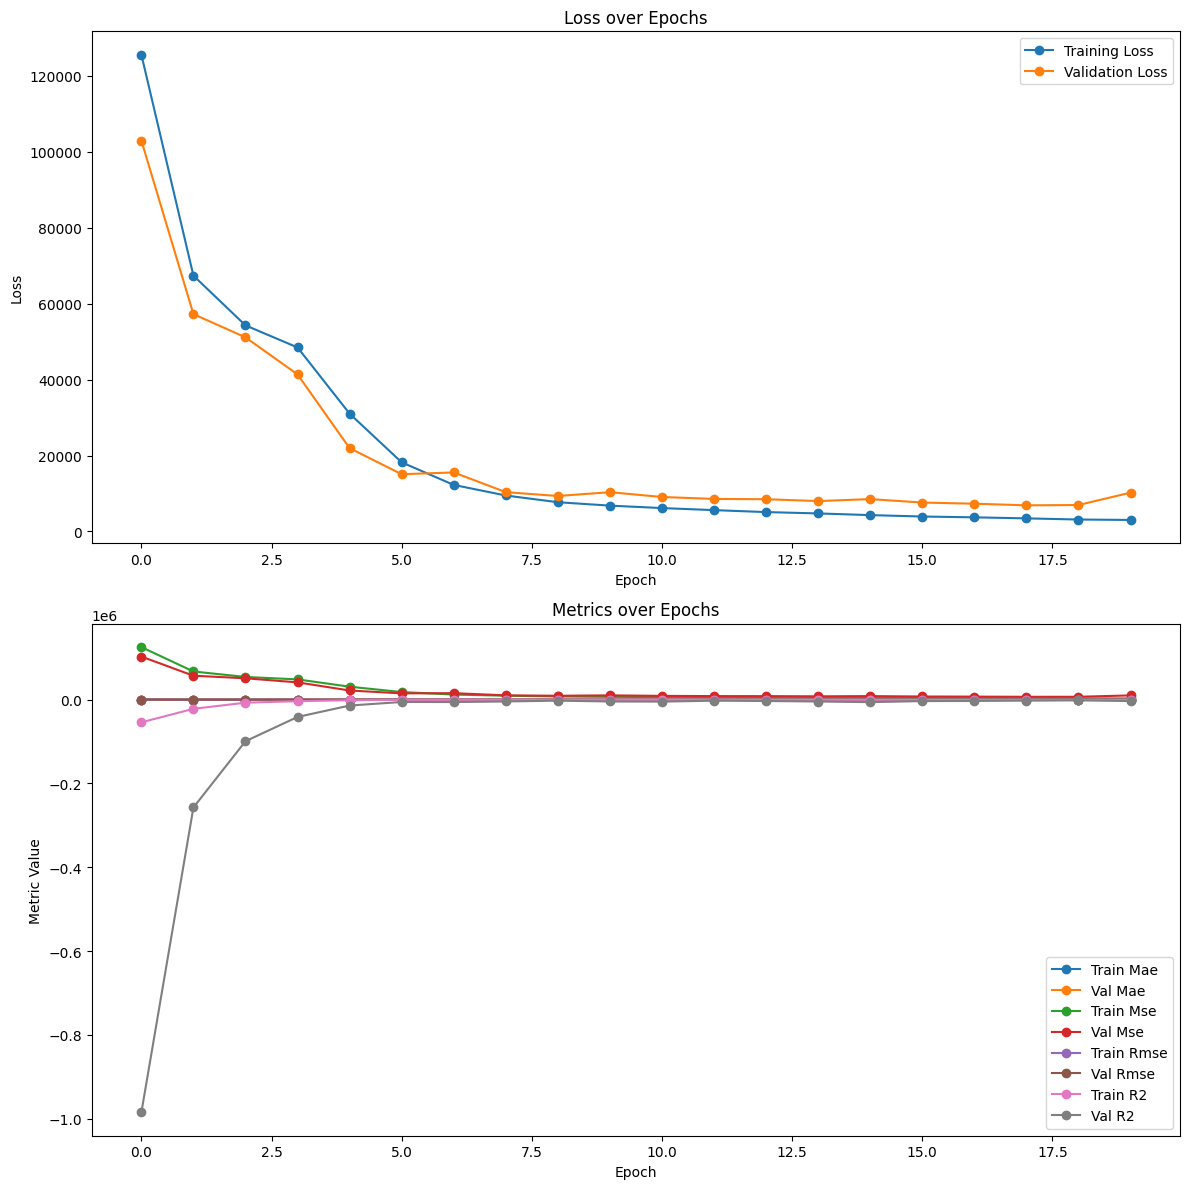

Training metrics:
{'mae': 22.686872482299805, 'mse': 2616.47705078125, 'rmse': np.float64(51.15151073801486), 'r2': -96.30021667480469}
Validation metrics:
{'mae': 29.688575744628906, 'mse': 6883.48876953125, 'rmse': np.float64(82.96679317372252), 'r2': -2268.25390625}


In [12]:
from torch.utils.data import random_split

import torch.nn as nn
import torch.optim as optim

loss_fn = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)

# Create train and validation dataloaders (using a split of the existing dataset for demonstration)

# Define split ratio (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Create trainer instance
trainer = CNN_trainer(
    model=net,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=20,
    patience=7,
    verbose=True,
    checkpoint_path="landmark_model.pt",
    optimizer=optimizer,
    loss_fn=loss_fn
)

# Train model
trained_model, train_losses, val_losses, train_metrics, val_metrics = trainer.fit()

# Clean up GPU memory
sync_vram()